# **Detect Moving Objects**

In this notebook, we will detect moving objects from a drone video

In [1]:
import os
import sys
from glob import glob
import re
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append(r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge\RAFT\core')
sys.path.append(r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge')
     
from raft_utils import *

#### Get RAFT Model

In [3]:
model = load_model(r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge\RAFT\models\raft-sintel.pth", args=Args())

Get video sequence from Virat Video Dataset

In [4]:
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000352_05980_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

196

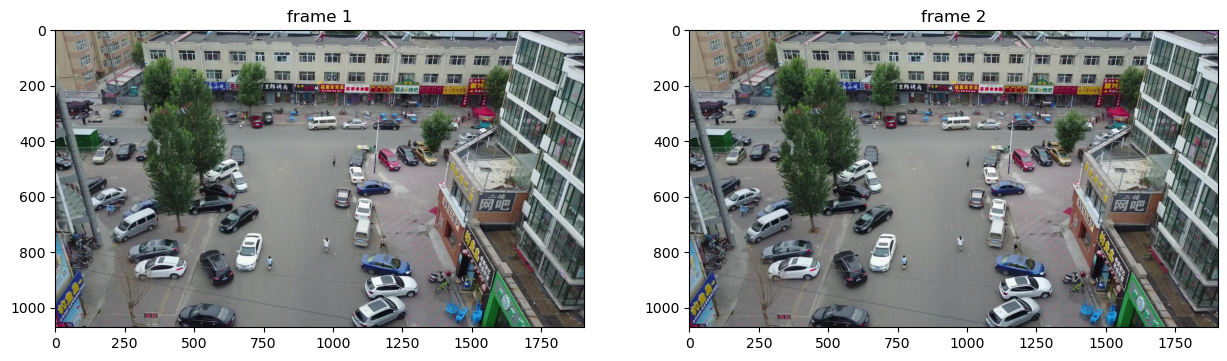

In [5]:
idx = 126
frame1 = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread(image_paths[idx + 1]), cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(cv2.imread(image_paths[idx + 2]), cv2.COLOR_BGR2RGB)
frame4 = cv2.cvtColor(cv2.imread(image_paths[idx + 3]), cv2.COLOR_BGR2RGB)

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

Compute Optical Flow between frames

- Divide frame into 16 areas 
- Compute optical flow with batchsize of 16

In [6]:
frame1.shape

(1071, 1904, 3)

In [7]:
x_index = np.linspace(0, frame1.shape[0] + 1, 5).astype(int)
y_index = np.linspace(0, frame1.shape[1] + 1, 5).astype(int)

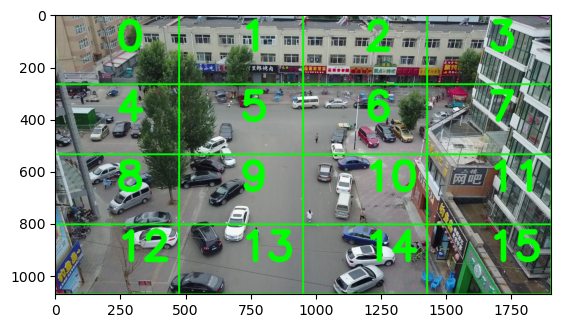

In [8]:
img = frame1.copy()
area_idx = 0
areas = []
for i in range(len(x_index) - 1):
    for j in range(len(y_index) - 1):  

        areas.append(frame1[x_index[i]:x_index[i+1], y_index[j]:y_index[j+1], :])
        # print(areas[-1].shape)

        x1, y1, x2, y2 = x_index[i], y_index[j], x_index[i+1], y_index[j+1]

        cv2.line(img,(0,x2),(1904,x2),(0,255,0),5)
        cv2.line(img,(y2,0),(y2,1071),(0,255,0),5)

        # draw number in each area
        org = (int((y1+y2)//2), int((x1+x2)//2)) 
        image = cv2.putText(img, f"{area_idx}", org, fontFace=cv2.FONT_HERSHEY_SIMPLEX,  
                            fontScale=5, color=(0,255,0), thickness=20, lineType=cv2.LINE_AA) 

        area_idx += 1

plt.imshow(img);

In [9]:
def get_areas(frame, x_index=x_index, y_index=y_index, w=1904, h=1071):
    """ Obtains sliced image frame for RAFT tensor input """

    # get new width and height
    w2 = x_index[1] - x_index[0]
    h2 = y_index[1] - y_index[0]

    # divide frame into areas
    areas = []
    for i in range(len(x_index) - 1):
        for j in range(len(y_index) - 1):  
            areas.append(
                cv2.resize(frame[x_index[i]:x_index[i+1], y_index[j]:y_index[j+1], :], dsize=(h2,w2))
            )

    return np.array(areas)

In [10]:
frame1_areas = get_areas(frame1)
frame2_areas = get_areas(frame2)

In [11]:
def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = torch.from_numpy(frame1).permute(0, 3, 1, 2).float().to(device)
        frame2 = torch.from_numpy(frame2).permute(0, 3, 1, 2).float().to(device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)
          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters
        

# Farneback Optical Flow
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # # blurr image
    # gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    # gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)


    return flow

In [12]:
flow = inference(model, frame1_areas, frame2_areas, iters=12, test_mode=False, device='cuda')[-1]

c:\Users\itber\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Reconstruct the flow estimate

In [13]:
flow = flow.permute(0, 2, 3, 1).cpu().numpy()

# flow = np.vstack((
#     np.hstack([flow[i, ...] for i in range(0, 2)]),
#     np.hstack([flow[i, ...] for i in range(2, 4)])
# ))

flow = np.vstack((
    np.hstack([flow[i, ...] for i in range(0, 4)]),
    np.hstack([flow[i, ...] for i in range(4, 8)]),
    np.hstack([flow[i, ...] for i in range(8, 12)]),
    np.hstack([flow[i, ...] for i in range(12, 16)])
))

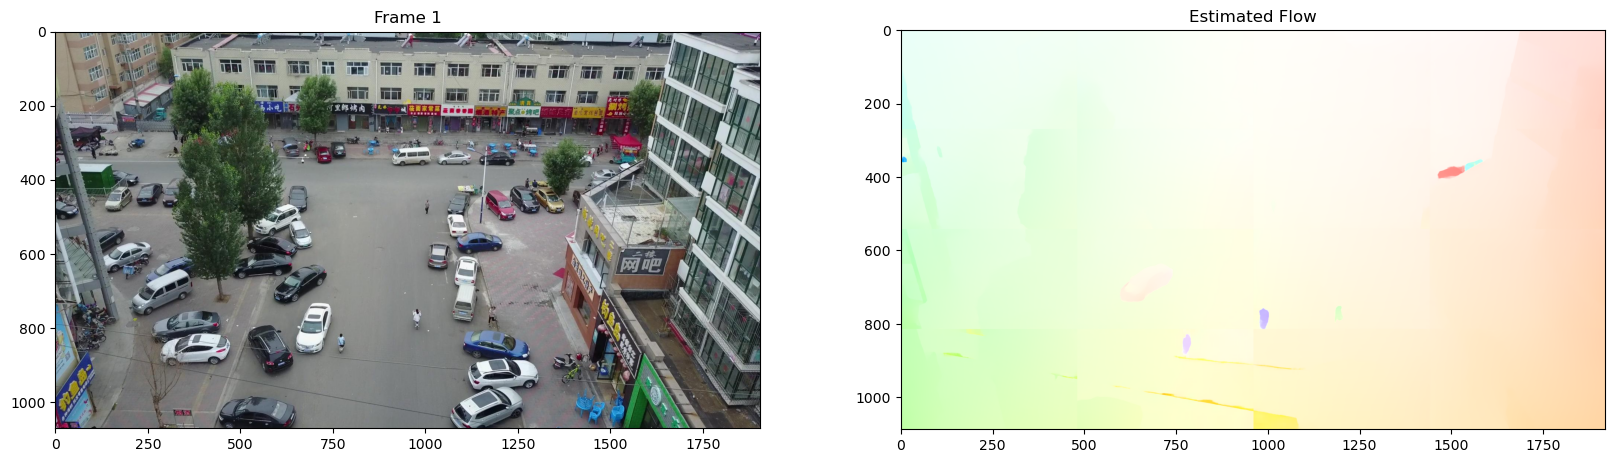

In [14]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(frame1)
ax[0].set_title("Frame 1")
ax[1].imshow(flow_viz.flow_to_image(flow))
ax[1].set_title("Estimated Flow");

# **Camera Motion Compensation**

Now we will implement camera motion compensation to get a better flow estimate with a moving ego camera

In [15]:
def motion_comp(frame1, frame2, num_points=500):
    """ Obtains new warped frame1 to account for camera (ego) motion
        """
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    # get features for first frame
    corners = cv2.goodFeaturesToTrack(gray1, num_points, qualityLevel=0.01, minDistance=10)

    # get matching features in next frame
    matched_corners, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, corners, None)

    # reformat previous and current corner points
    prev_points = corners[status==1]
    curr_points = matched_corners[status==1]

    # find translation matrix from frame 1 to frame 2
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    # warp frame 1 to account for camera motion
    warped = cv2.warpAffine(frame1, A, dsize=(gray1.shape[::-1]))

    return A, warped

Get warped/transformed frame 1

In [16]:
A, transformed1 = motion_comp(frame1, frame2, num_points=1000)

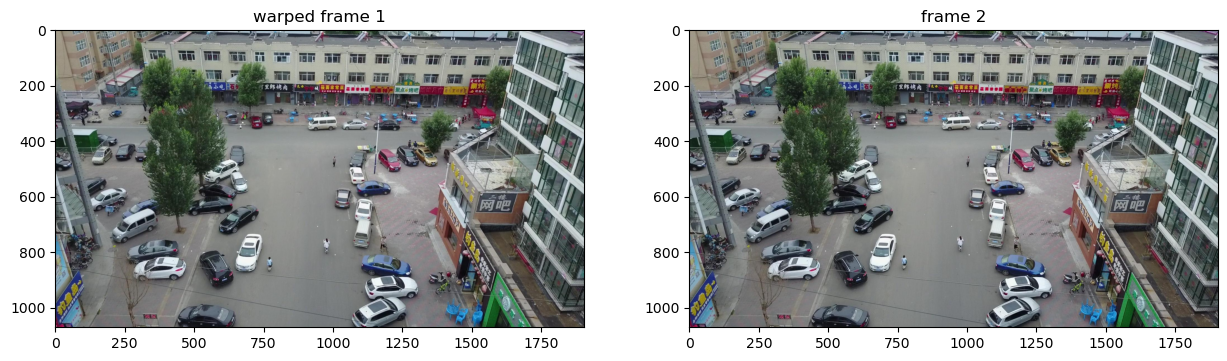

In [17]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(transformed1)
ax[0].set_title("warped frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

In [18]:
frame1_areas = get_areas(transformed1)
frame2_areas = get_areas(frame2)

In [19]:
flow_low, flow_up = inference(model, frame1_areas, frame2_areas, device='cuda')

In [20]:
flow = flow_up.permute(0, 2, 3, 1).cpu().numpy()

flow = np.vstack((
    np.hstack([flow[i, ...] for i in range(0, 4)]),
    np.hstack([flow[i, ...] for i in range(4, 8)]),
    np.hstack([flow[i, ...] for i in range(8, 12)]),
    np.hstack([flow[i, ...] for i in range(12, 16)])
))

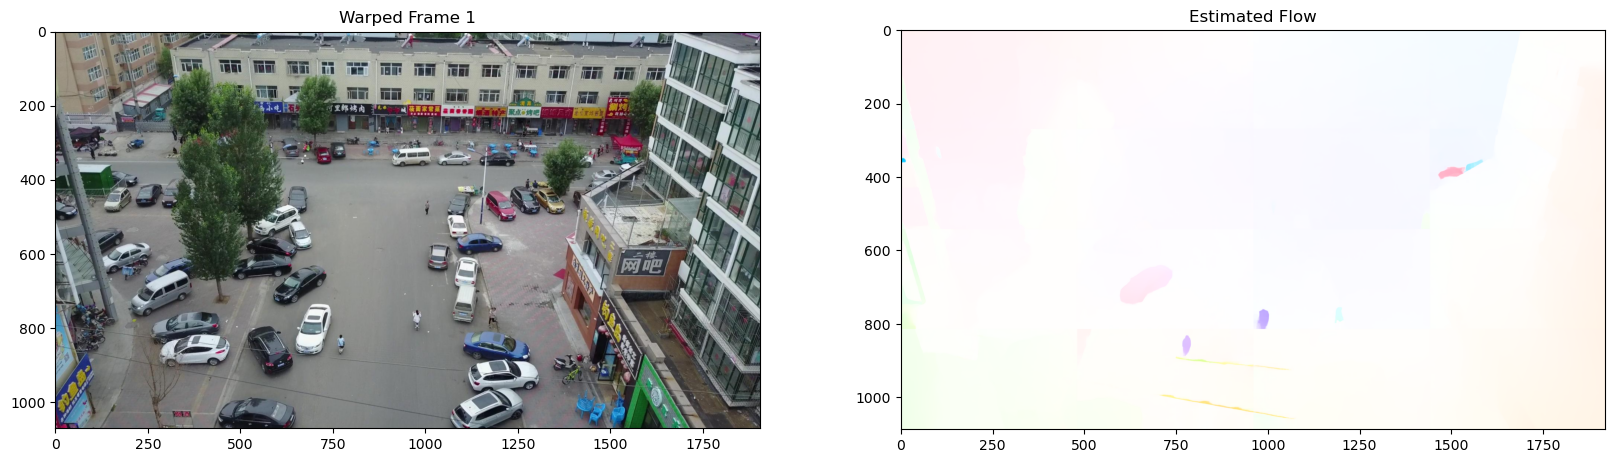

In [21]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(transformed1)
ax[0].set_title("Warped Frame 1")
ax[1].imshow(flow_viz.flow_to_image(flow))
ax[1].set_title("Estimated Flow");

In [22]:
def get_motion(flow, thresh=10):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # thresh = np.c_[np.linspace(5, 12, mag.shape[0])].repeat(mag.shape[1], axis=-1)
    # motion = np.uint8(mag > thresh)*255
    _, motion = cv2.threshold(mag, thresh=thresh, maxval=255, type=cv2.THRESH_BINARY) 
    motion = cv2.morphologyEx(motion, cv2.MORPH_OPEN, kernel=np.ones((7,7)), iterations=1).astype(np.uint8)

    return motion

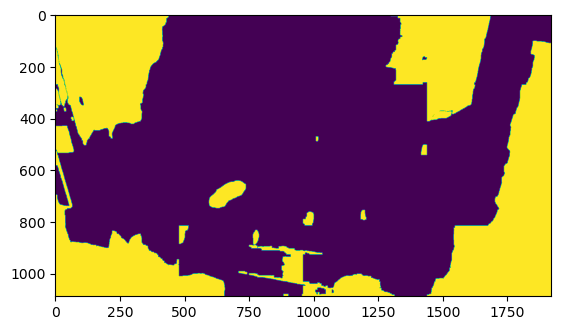

In [23]:
motion = get_motion(flow, thresh=0.75)
plt.imshow(motion);

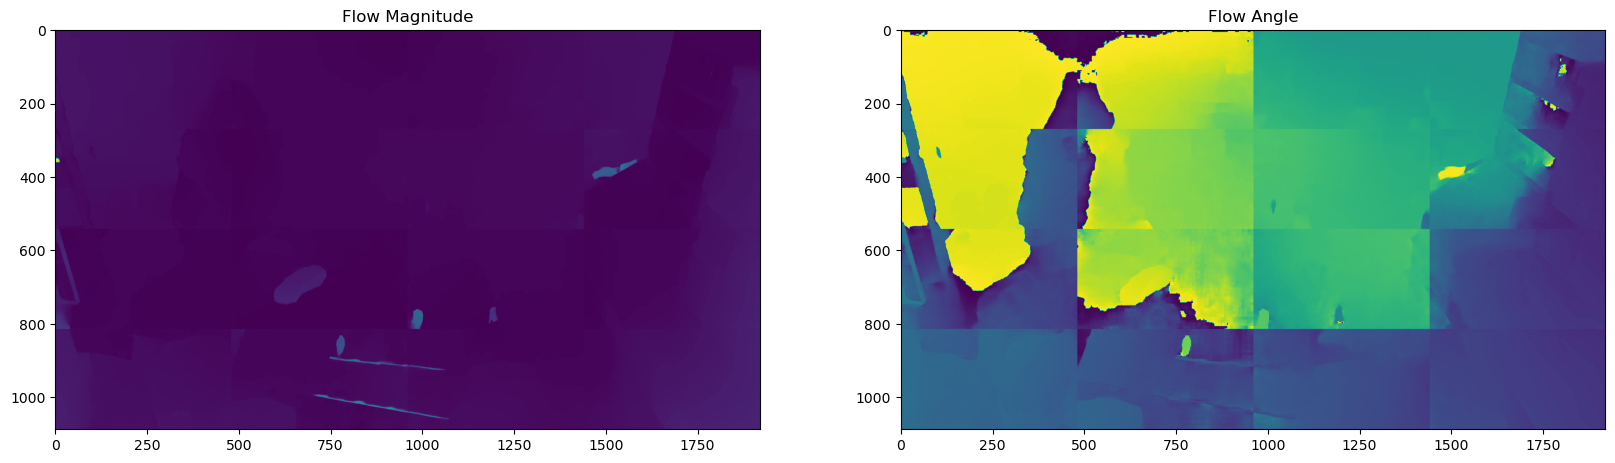

In [88]:
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mag)
ax[0].set_title("Flow Magnitude")
ax[1].imshow(cv2.normalize(ang, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1))
ax[1].set_title("Flow Angle");

Get angle bins

In [25]:
2*np.pi*180/np.pi

360.0

In [26]:
angle_bin_1 = (ang > 0) & (ang <= np.pi/4)
angle_bin_2 = (ang > np.pi/4) & (ang <= np.pi/2)
angle_bin_3 = (ang > np.pi/2) & (ang <= 3*np.pi/4)
angle_bin_4 = (ang > 3*np.pi/4) & (ang <= np.pi)
angle_bin_5 = (ang > np.pi) & (ang <= 3*np.pi/2)
angle_bin_6 = (ang > 3*np.pi/2) & (ang <= 2*np.pi)

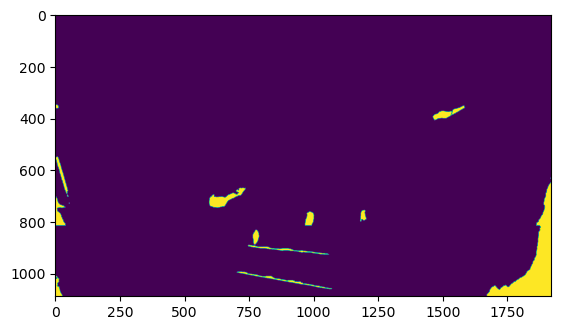

In [27]:
plt.imshow(mag > 2)

In [68]:
B = 6

for b in range(1, B + 1):
    # print(-np.pi/2 + np.pi*(b - 1)/B, -np.pi + np.pi*b/B)
    print(np.degrees(-np.pi/2 + np.pi*(b - 1)/B), np.degrees(-np.pi + np.pi*b/B))

-90.0 -150.0
-60.00000000000001 -120.00000000000001
-30.000000000000004 -90.0
0.0 -60.00000000000001
29.999999999999993 -29.999999999999993
60.00000000000001 0.0


refs: 
- https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=10825B3DBCC638B0A34568642BF55C8D?doi=10.1.1.422.527&rep=rep1&type=pdf
- https://github.com/allenyangyl/Face_Liveness_Detection/blob/master/Matlab/HOOF/gradientHistogram.m

In [49]:
binSize = 150

# agnitudeImage   = (Fx.^2 + Fy.^2 ).^0.5;
# orientationImage =  atan2(Fy,Fx);

magnitudeImage   = ((flow[..., 0]**2) + (flow[..., 1]**2) )**0.5;
orientationImage =  np.arctan2(flow[..., 0], flow[..., 1])

# greaterPiBy2Index = orientationImage > pi/2;
# smallerMinusPiBy2Index = orientationImage < -pi/2;
# remainingIndex = orientationImage <=pi/2 & orientationImage >= -pi/2;

greaterPiBy2Index = orientationImage > np.pi/2
smallerMinusPiBy2Index = orientationImage < -np.pi/2
remainingIndex = (orientationImage <= np.pi/2) & (orientationImage >= -np.pi/2)

# greaterPiBy2Mat = greaterPiBy2Index.*orientationImage;
# smallerMinusPiBy2Mat = smallerMinusPiBy2Index.*orientationImage;
# remainingMat = remainingIndex.*orientationImage;

greaterPiBy2Mat = greaterPiBy2Index*orientationImage
smallerMinusPiBy2Mat = smallerMinusPiBy2Index*orientationImage
remainingMat = remainingIndex*orientationImage

# piMat = pi*ones(size(orientationImage));

piMat = np.pi*np.ones_like(orientationImage)

# convertGreaterPiBy2Mat = greaterPiBy2Index.*piMat - greaterPiBy2Mat;
# convertSmallerMinusPiBy2Mat = smallerMinusPiBy2Index.*(-piMat) - smallerMinusPiBy2Mat;

convertGreaterPiBy2Mat = greaterPiBy2Index*piMat - greaterPiBy2Mat
convertSmallerMinusPiBy2Mat = smallerMinusPiBy2Index*(-piMat) - smallerMinusPiBy2Mat

# newOrientationImage = convertGreaterPiBy2Mat + remainingMat + convertSmallerMinusPiBy2Mat;

newOrientationImage = convertGreaterPiBy2Mat + remainingMat + convertSmallerMinusPiBy2Mat

# % [hog,idx] =
# % histc(reshape(orientationImage,1,[]),linspace(-pi,pi,binSize+1) );
# [hog,idx] = histc(reshape(newOrientationImage,1,[]),linspace(-pi/2,pi/2,binSize+1) );
# values = reshape(magnitudeImage,1,[]);

counts, edges= np.histogram(orientationImage.flatten(), np.linspace(-np.pi, np.pi, binSize + 1))
# counts, edges = np.histogram(newOrientationImage.flatten(), np.linspace(-np.pi/2, np.pi/2, binSize + 1))

# get indexes at each bin edge
idx = np.digitize(orientationImage.flatten(), np.linspace(-np.pi, np.pi, binSize + 1))
# idx = np.digitize(newOrientationImage.flatten(), np.linspace(-np.pi/2, np.pi/2, binSize + 1))
values = magnitudeImage.flatten()

# for k=1:binSize
#     bin(k) = sum(values(find(idx==k)));
# end

bins = np.zeros((binSize))
for k in range(binSize):
    bins[k] = np.sum(values[idx == k])

# ohog = bin/sum(bin);
hoof = bins/np.sum(bins)

# ohog = ohog';

In [50]:
idx.min(), idx.max()

(1, 150)

<BarContainer object of 150 artists>

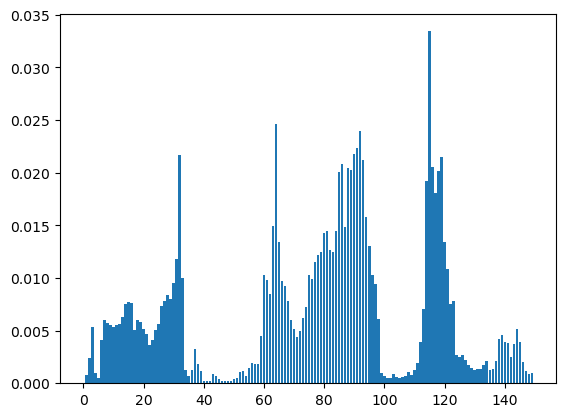

In [51]:
plt.bar(np.arange(0, binSize), hoof)

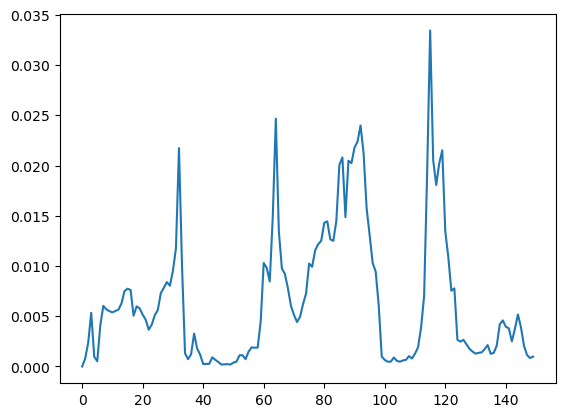

In [52]:
plt.plot(hoof)

Now use some local filter to select peaks

In [74]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(hoof, height=np.max(hoof)/5, distance=1)

In [75]:
peaks

array([ 15,  28,  32,  60,  64,  75,  81,  86,  88,  92, 115, 119, 123],
      dtype=int64)

In [76]:
magnitudeImage.shape

(1088, 1920)

In [77]:
values.shape, idx.shape

((2088960,), (2088960,))

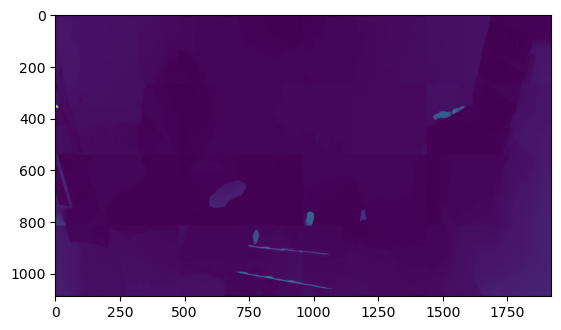

In [78]:
plt.imshow(values.reshape((1088, 1920)))

In [79]:
np.shape(idx == 8)

(2088960,)

In [80]:
np.reshape(idx == 8, newshape=(1088, 1920))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

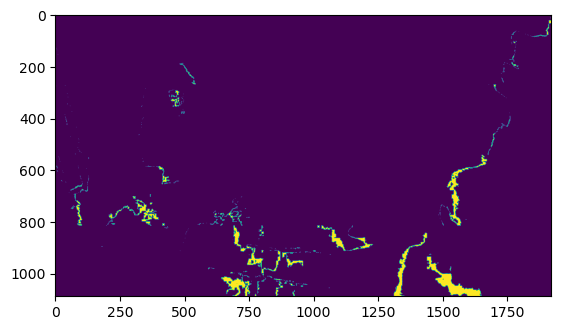

In [87]:
plt.imshow(np.reshape(idx == peaks[6], newshape=(1088, 1920)))

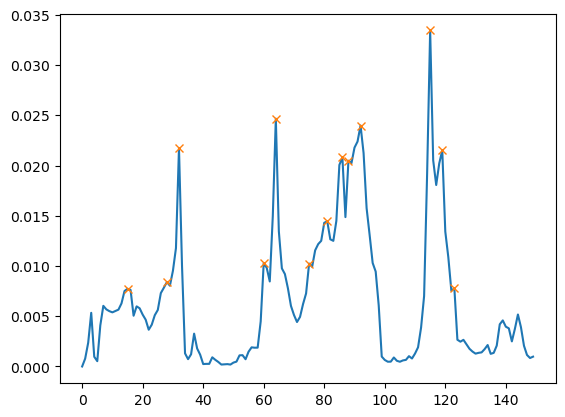

In [82]:
plt.plot(hoof)
plt.plot(peaks, hoof[peaks], "x")

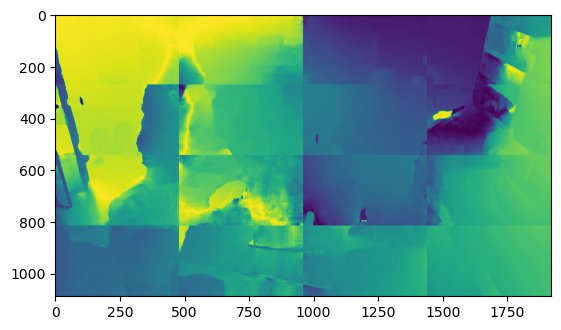

In [92]:
plt.imshow(newOrientationImage)

In [61]:
mask = ((mag > 2) & angle_bin_1) \
       | ((mag > 2) & angle_bin_2) \
       | ((mag > 2) & angle_bin_3) \
       | ((mag > 2) & angle_bin_4) \
       | ((mag > 2) & angle_bin_5) \
       | ((mag > 2) & angle_bin_6) 

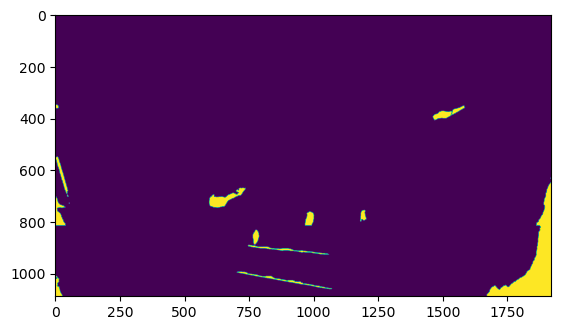

In [62]:
plt.imshow(mask)

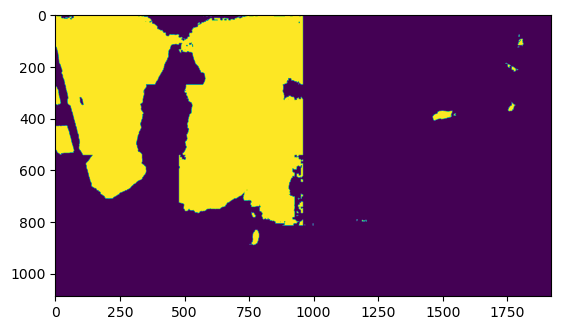

In [42]:
plt.imshow(angle_bin_6)

In [24]:
def get_initial_detections(mask, thresh_lo=100, thresh_hi=100000):
    """ Obtains initial proposed detections from the mask.
        Inputs:
            mask - thresholded image mask
        Outputs:
            detectons - list of proposed detection bounding boxes
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)

    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if (area > thresh_lo) and (area < thresh_hi):
            detections.append([x,y,x+w,y+h])

    return detections

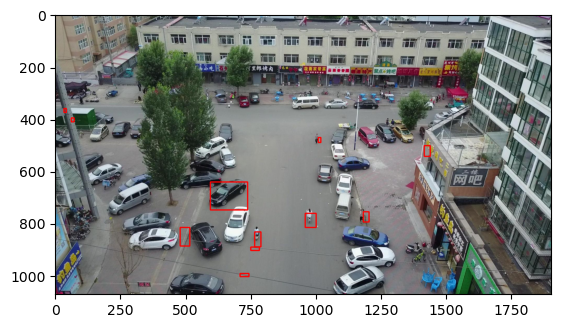

In [25]:
mask_rgb = cv2.cvtColor(motion, cv2.COLOR_GRAY2RGB)
img = frame2.copy()
detections = get_initial_detections(motion)

for det in detections:
    x1,y1,x2,y2 = det
    # cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)
    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 3)

# plt.imshow(mask_rgb);
plt.imshow(img);

In [26]:
def get_detections(frame1, frame2, motion_thresh=5, thresh_lo=100, thresh_hi=100000):
    # get warped frame 1
    _, transformed1 = motion_comp(frame1, frame2, num_points=1000)

    # get partioned image areas
    frame1_areas = get_areas(transformed1)
    frame2_areas = get_areas(frame2)


    # compute dense optical flow
    _, flow_up = inference(model, frame1_areas, frame2_areas, device='cuda')

    # reconstruct flow
    flow = flow_up.permute(0, 2, 3, 1).cpu().numpy()

    flow = np.vstack((
        np.hstack([flow[i, ...] for i in range(0, 4)]),
        np.hstack([flow[i, ...] for i in range(4, 8)]),
        np.hstack([flow[i, ...] for i in range(8, 12)]),
        np.hstack([flow[i, ...] for i in range(12, 16)])
    ))

    # get motion mask
    motion = get_motion(flow, thresh=motion_thresh)

    # get initial bounding box detections
    detections = get_initial_detections(motion, thresh_lo, thresh_hi)

    # Non-Max Supression 

    return detections

In [ ]:
%timeit _, transformed1 = motion_comp(frame1, frame2, num_points=1000)

In [ ]:
%timeit _, flow_up = inference(model, frame1_areas, frame2_areas, device='cuda')

539 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit detections = get_detections(frame1, frame2)

635 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Iterate through all frames

In [193]:
frames = []
for i in range(len(image_paths) - 1):
    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])

    detections = get_detections(frame1, frame2, motion_thresh=0.75, thresh_lo=100, thresh_hi=100000)

    # draw detections
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame2, (x1,y1), (x2,y2), (255,0,0), 3)
    
    frames.append(frame2)

#### Make Video

In [194]:
out = cv2.VideoWriter('drone_detection_RAFT_3.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25, (1904, 1071))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

## Use tracker to remove spurous detections

In [27]:
def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    blue = int(number*30 % 256)
    green = int(number*103 % 256)
    red = int(number*50 % 256)

    return red, blue, green

In [43]:
from sort import Sort

tracker = Sort(max_age=5, 
               min_hits=2,
               iou_threshold=0.01)

In [44]:
frames = []
for i in range(len(image_paths) - 1):
    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])

    detections = get_detections(frame1, frame2, motion_thresh=0.75, thresh_lo=100, thresh_hi=100000)

    if len(detections) > 0:
        dets = np.hstack((detections, np.ones((len(detections), 1))))
        # print(dets.shape)
    else:
        dets = np.empty((0, 5))

    trackers = tracker.update(dets)
    # print(trackers.shape)


    # draw tracks
    for d in trackers:
        x1,y1,x2,y2,trk_id = d.astype(np.int32)

        cv2.rectangle(frame2, (x1,y1), (x2,y2), get_color(trk_id), 3)
    
    frames.append(frame2)

    # if i == 10:
    #     print(STOP)

In [45]:
%matplotlib inline

In [60]:
plt.imshow(frames[1])
plt.show()

IndexError: list index out of range

In [47]:
out = cv2.VideoWriter('drone_tracker_RAFT_4.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25, (1904, 1071))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

## Iterate through all frames and get Optical Flow

In [395]:
frames = []
flows = []
for i in range(len(image_paths) - 1):

    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])    
    
    # get warped frame 1
    _, transformed1 = motion_comp(frame1, frame2, num_points=1000)

    # get partioned image areas
    frame1_areas = get_areas(transformed1)
    frame2_areas = get_areas(frame2)


    # compute dense optical flow
    _, flow_up = inference(model, frame1_areas, frame2_areas, device='cuda')

    # reconstruct flow
    flow = flow_up.permute(0, 2, 3, 1).cpu().numpy()

    flow = np.vstack((
        np.hstack([flow[i, ...] for i in range(0, 4)]),
        np.hstack([flow[i, ...] for i in range(4, 8)]),
        np.hstack([flow[i, ...] for i in range(8, 12)]),
        np.hstack([flow[i, ...] for i in range(12, 16)])
    ))

    flows.append(flow)
    frames.append(frame2)

    if i == 50:
        print(STOP)

NameError: name 'STOP' is not defined

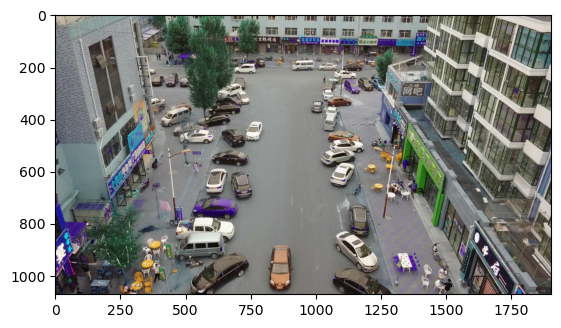

In [ ]:
plt.imshow(frame2)

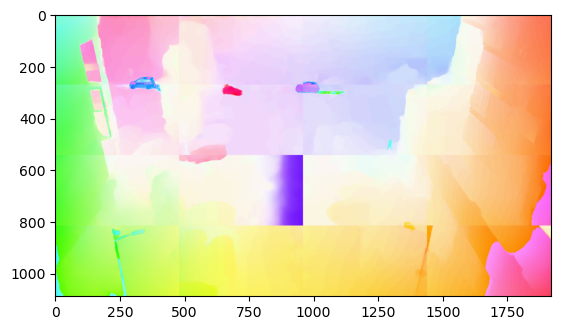

In [130]:
plt.imshow(flow_viz.flow_to_image(flows[-7])*5)

### Create a Median based filter to remove spurious hallucinations

Actual Flow filter!

In [ ]:
# n = 5
# o = 0 # index offset

# flow_block = np.zeros_like(flows[0])[None, ...].repeat(n, axis=0)
# filtered_flows = []

# # iterate through all flows
# for i in range(len(flows)):
#     if i >= n:
#         for j in range(n):
#             print(i + j - o, i + j - n)

#             # populate the flow block
#             flow_block[i + j - o, ...] = flows[i + j - n]
        
#         print(i, i + j - n)
#         x = flows[i + j - n].copy()

#         med = np.median(flow_block, axis=0)

#         # compute MAD scale factor
#         s = 1.4826 * np.median(flow_block - med, axis=0)

#         # perform filtering
#         mask = np.abs(x - med) > c*s
#         x[mask] = med[mask]

#         filtered_flows.append(x)
#     elif i < n - 1:
#         print(i)
#         filtered_flows.append(flows[i])
    
#     # update the offset
#     o += 1

#     # print()

#     if i == 10:
#         break

In [57]:
# TEMP - to get proper flow dimensions
flow = compute_flow(transformed1, frame2)

In [58]:
n = 3 # number of taps for filter
c = 3 # tunable hyperparameter
o = 0 # index offset

deep_flow= False # use RAFT or Farneback to compute Dense Optical Flow

# # get proper flow dimensions 
# if deep_flow:
#     flow_x, flow_y = 1080, 1920
# else:
#     flow_x, flow_y = 1080, 1920

# detection hyperparameters
motion_thresh=2
thresh_lo = 100
thresh_hi = 100000

flow_block = np.zeros_like(flow)[None, ...].repeat(n, axis=0)
filtered_flows = []

frames = []


for i in range(len(image_paths) - 1):

    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])    
    
    # get warped frame 1
    _, transformed1 = motion_comp(frame1, frame2, num_points=1000)

    # ================================================================================
    # compute optical flow
    if deep_flow:
        # get partioned image areas
        frame1_areas = get_areas(transformed1)
        frame2_areas = get_areas(frame2)


        # compute dense optical flow
        _, flow_up = inference(model, frame1_areas, frame2_areas, device='cuda')

        # reconstruct flow
        flow = flow_up.permute(0, 2, 3, 1).cpu().numpy()

        flow = np.vstack((
            np.hstack([flow[i, ...] for i in range(0, 4)]),
            np.hstack([flow[i, ...] for i in range(4, 8)]),
            np.hstack([flow[i, ...] for i in range(8, 12)]),
            np.hstack([flow[i, ...] for i in range(12, 16)])
        ))
    else:
        flow = compute_flow(transformed1, frame2)

    # ================================================================================
    # filter Optical Flow
    if i >= n:
        for j in range(n):
            # print(i + j - o, i + j - n)

            # populate the flow block
            flow_block[i + j - o, ...] = flow # flows[i + j - n]
        
        # print(i, i + j - o, i + j - n)
        x = flow.copy() # flows[i + j - n].copy()

        med = np.median(flow_block, axis=0)

        # compute MAD scale factor
        s = 1.4826 * np.median(flow_block - med, axis=0)

        # perform filtering
        mask = np.abs(x - med) > c*s
        x[mask] = med[mask]

        filtered_flows.append(x)
    elif i < n - 1:
        # print(i)
        filtered_flows.append(flow) # flows[i])
    
    # update the offset
    o += 1
    # ================================================================================

    ##  get detections
    # get motion mask
    motion = get_motion(flow, thresh=motion_thresh)

    # get initial bounding box detections
    detections = get_initial_detections(motion, thresh_lo, thresh_hi)
    
    # draw detections
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame2, (x1,y1), (x2,y2), (255,0,0), 3)
    
    frames.append(frame2)


    # if i == 50:
    #     print(STOP)

In [59]:
len(filtered_flows)

194

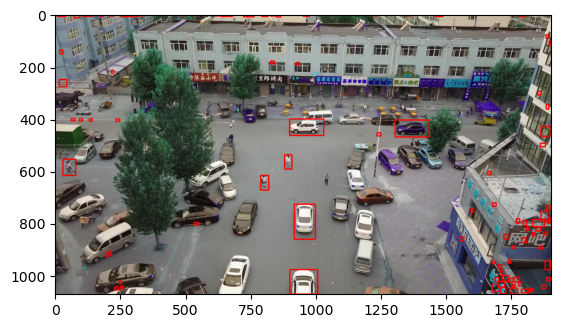

In [60]:
plt.imshow(frames[-1])

In [61]:
out = cv2.VideoWriter('drone_detection_filtered_1.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25, (1904, 1071))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

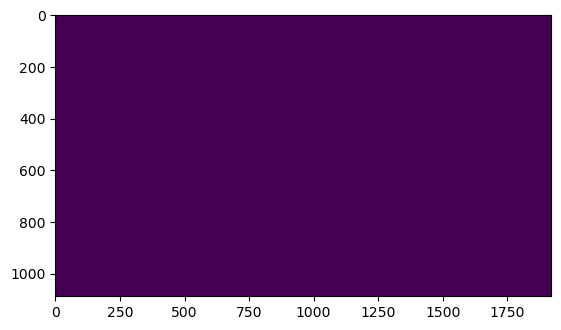

In [411]:
plt.imshow(x[:, :, 1] < -10)

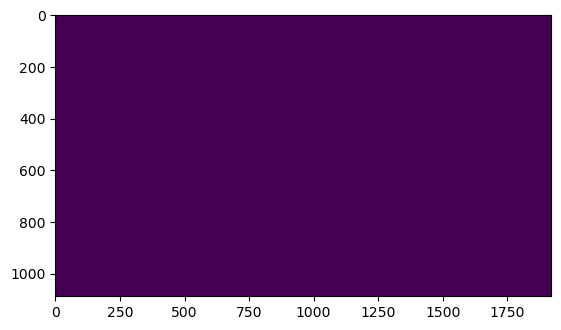

In [412]:
plt.imshow(flows[i][:, :, 1] < -10)

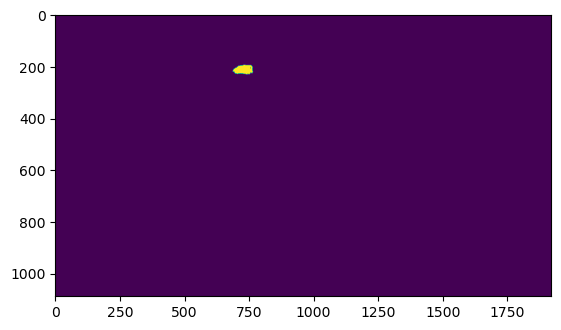

In [416]:
plt.imshow(x[:, :, 0] < -5)

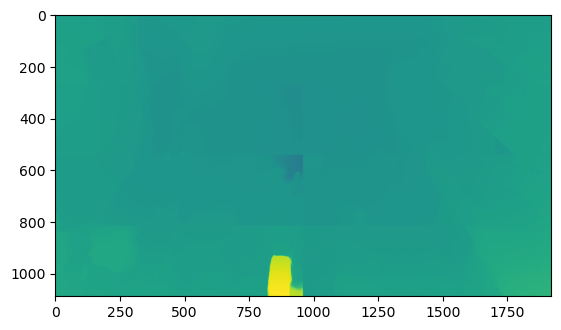

In [406]:
plt.imshow(x[..., 1])

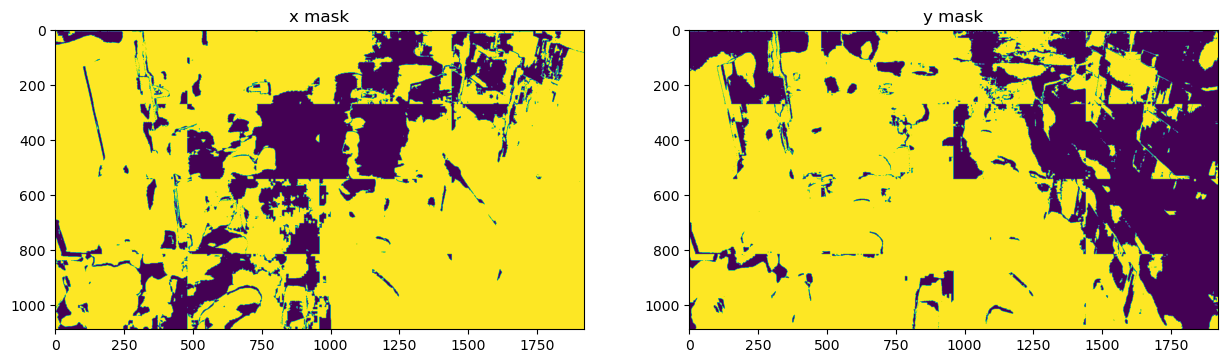

In [407]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(mask[..., 0])
ax[0].set_title("x mask")
ax[1].imshow(mask[..., 1])
ax[1].set_title("y mask");

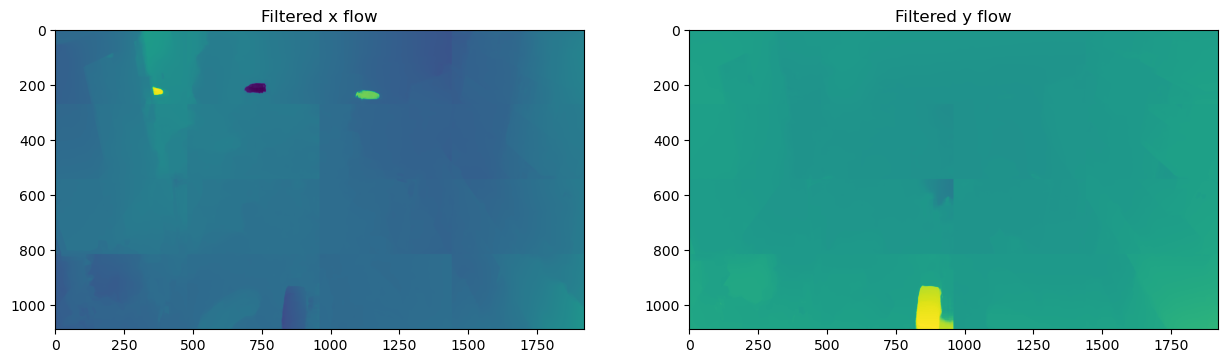

In [409]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(x[..., 0])
ax[0].set_title("Filtered x flow")
ax[1].imshow(x[..., 1])
ax[1].set_title("Filtered y flow");

In [51]:
mag, ang = cv2.cartToPolar(x[..., 0], x[..., 1])

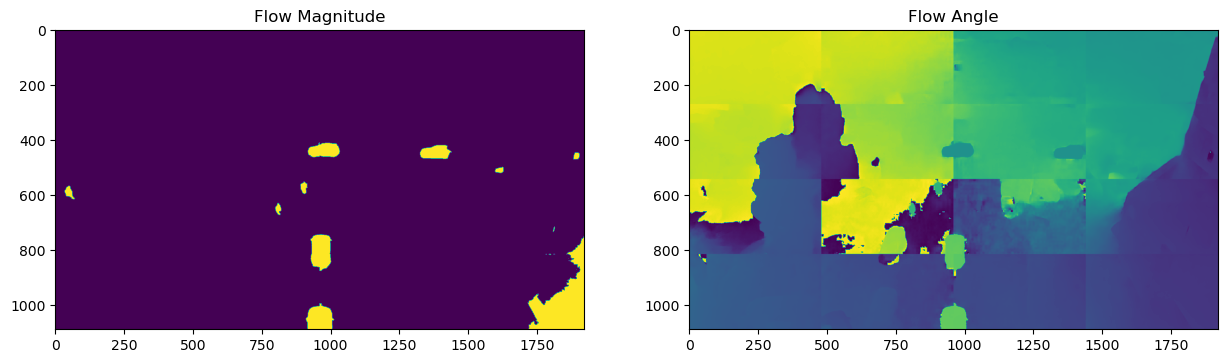

In [53]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(mag > 2)
ax[0].set_title("Flow Magnitude")
ax[1].imshow(ang)
ax[1].set_title("Flow Angle");

In [422]:
X = np.vstack((ang.flatten(), mag.flatten())).T
X.shape

(2088960, 2)

In [ ]:
plt.hist(ang.flatten(), bins=100);

In [ ]:
plt.himag.flatten()

In [142]:
flow_block.shape

(3, 1088, 1920, 2)

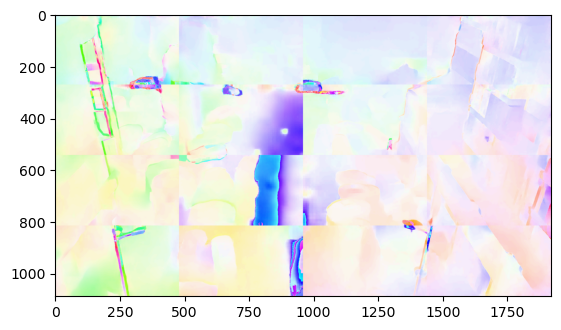

In [133]:
plt.imshow(flow_viz.flow_to_image(flows[-8] - flows[-7])*5)

In [ ]:
motion_thresh = 2

left_motion = (flow[:, :, 0] < -motion_thresh).astype(np.uint8)*255
right_motion = (flow[:, :, 0] > motion_thresh).astype(np.uint8)*255

up_motion = (flow[:, :, 1] < -motion_thresh).astype(np.uint8)*255
down_motion = (flow[:, :, 1] > motion_thresh).astype(np.uint8)*255

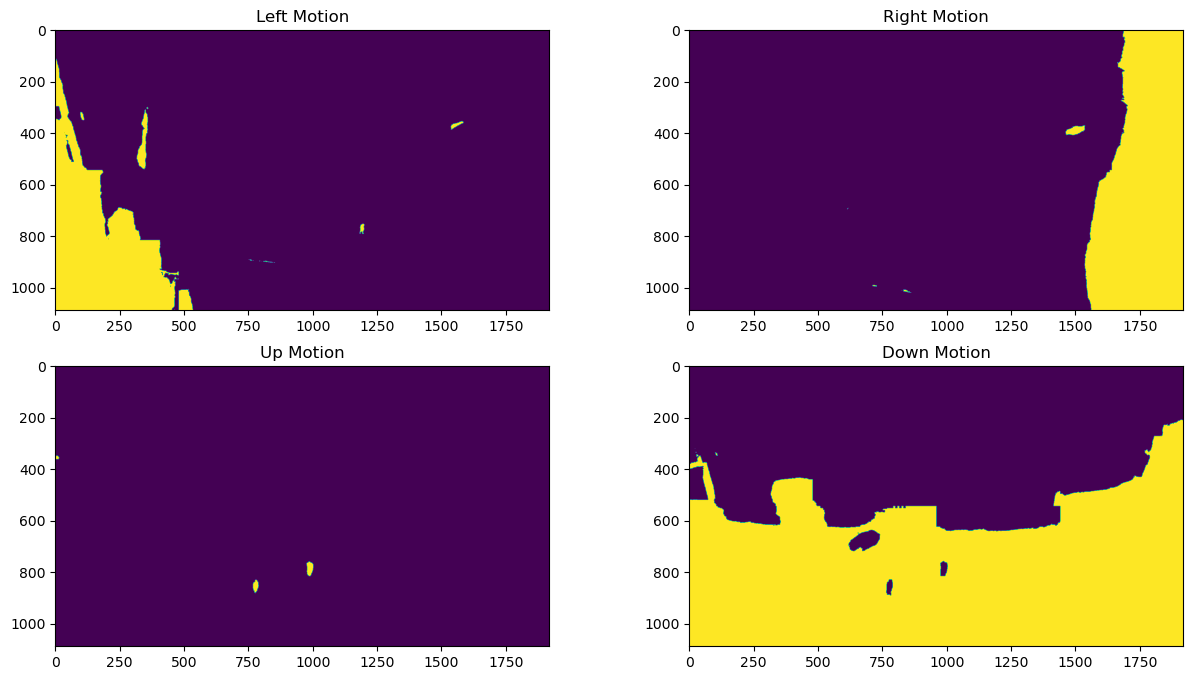

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].imshow(left_motion)
ax[0][0].set_title("Left Motion")

ax[0][1].imshow(right_motion)
ax[0][1].set_title("Right Motion")

ax[1][0].imshow(up_motion)
ax[1][0].set_title("Up Motion")

ax[1][1].imshow(down_motion)
ax[1][1].set_title("Down Motion");